<center><h1>1-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [212]:
# !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/2-ab.zip
# !unzip -j 2-ab.zip
# !wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-ab/utils-data.py

In [213]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'utils-data.py'

device = torch.device("cpu")
dtype = torch.float

# Part 1 : Forward and backward passes "by hands"

In [214]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers (dimensions of input, hidden and output layers)
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by
    #initialize randomly with some gaussian functions (not all zero, initialization does matter!)

    #All weights will be initialized according to a normal distribution of mean 0 and standard deviation 0.3.
    params["Wh"] = torch.randn(nh, nx, device=device, dtype=dtype) * 0.3
    params["Wy"] = torch.randn(nh, ny) * 0.3
    params["bh"] = torch.zeros(nh, 1)
    params["by"] = torch.zeros(ny, 1) 

    ####################
    ##      END        #
    ####################
    return params

In [215]:
def linear_affine_transformation(W, X, b):
    """ 
    linear transformation: ŷ = f (x) = W x with W a matrix of size ny x nx . This transformation is the standard layer of classical
neural networks. As a side note, we often use an affine transformation f (x) = W x + b, where b a vector of
size ny .
    """
    return torch.mm(W,X) + b

def activation_function_tanh(x):
    return torch.tanh(x)

def activation_function_softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=0)

def activation_function_sigmoid(x):
    return 1/(1+torch.exp(-x))

def activation_function_relu(x):
    return torch.max(torch.zeros(x.size()), x)


In [216]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    
    Write the function forward (params, X) which calculates the intermediate steps and the output
of the network from an input batch X of size nbatch * nx and weights stored in params and store
them in a dictionary. We return the dictionary of intermediate steps and the output Ŷ of the network.
Hint: we will use torch.mm for matrix multiplication, and torch.tanh, torch.exp, torch.sum
    """
    bsize = X.size(0) #size nbatch * nx 
    nh = params['Wh'].size(0) #matrix of weights Wh of size nh × nx
    ny = params['Wy'].size(0) #bias vector bh of size nh
    outputs = {}

    #####################
    ## Your code here  ##   
    #####################
    # fill values for X, htilde, h, ytilde, yhat
    
    outputs["X"] = X
    # print("linear affine transformation to get htilde")
    # print("X", outputs["X"].shape)
    # print("Wh",params["Wh"].shape)
    # print("bh",params["bh"].shape)
    outputs["htilde"] = linear_affine_transformation(params["Wh"], X.T, params["bh"])
    outputs["h"] = activation_function_tanh(outputs["htilde"])
    # print("linear affine transformation to get ytilde")
    # print("h", outputs["h"].shape)
    # print("Wy",params["Wy"].shape)
    # print("by",params["by"].shape)
    outputs["ytilde"] = linear_affine_transformation(outputs["h"].T,params["Wy"], params["by"].T)
    outputs["yhat"] = activation_function_softmax(outputs["ytilde"])

    ####################
    ##      END        #
    ####################

    #output all the intermediate values, useful for computing the gradient during the backward pass later

    return outputs['yhat'], outputs

In [217]:
def loss_accuracy(Yhat, Y):
    """
    Write the function loss_accuracy (Yhat, Y) which computes the cost function and the precision
(rate of good predictions) from an output matrix Ŷ (output of forward ) with respect to a ground
truth matrix Y of the same size, and returns the loss L and the precision acc .
Note: We will use the _, indsY = torch.max (Y, 1) function which returns the index of the
predicted class (or to be predicted) for each example.
Hints: torch.mean, torch.max, torch.log, torch.sum
    """

    #####################
    ## Your code here  ##
    #####################

    L = 0
    acc = 0 

    # Compute the cross-entropy loss
    L= -torch.mean(torch.sum(Y * torch.log(Yhat), dim=1))

    # Compute the precision (accuracy)
    _, indsY = torch.max(Y, 1)
    _, indsYhat = torch.max(Yhat, 1)
    correct_predictions = torch.sum(indsY == indsYhat)
    acc = torch.mean(correct_predictions.float())

    ####################
    ##      END        #
    ####################

    return L, acc

In [218]:
def backward(params, outputs, Y):
    """ 
    Write the function backward (params, outputs, Y) which calculates the gradients of the loss
with respect to the parameters and stores them in a dictionary.
    """
    bsize = Y.shape[0]
    grads = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wy, Wh, by, bh
    #use the formula on the backpropagation sheet


    print("Wy shape",params["Wy"].shape)
    print("Wh shape",params["Wh"].shape)
    print("by shape",params["by"].shape)
    print("bh shape",params["bh"].shape)
    print("h shape",outputs["h"].shape)
    print("yhat shape",outputs["yhat"].shape)

    grad_ytilde = outputs["yhat"] - Y
    print("grad y tilde shape",grad_ytilde.shape)
    grad_htilde =  grad_ytilde.mm(params["Wy"].T) * (1 - outputs["h"] ** 2) # Element-wise multiplication of grad_Y and Wy is done with .mm() function


    print("grad h tilde shape",grad_htilde.shape)

    grads["Wy"] = grad_ytilde.T.mm(outputs["h"])
    grads["Wh"] = grad_htilde.T.mm(outputs["X"])
    grads["by"] = grad_ytilde.T
    grads["bh"] = grad_htilde.T

    ####################
    ##      END        #
    ####################
    return grads

In [219]:
def sgd(params, grads, eta):
    """
    Write the function sgd (params, grads, eta) which applies a stochastic gradient descent by
mini-batch and updates the network parameters from their gradients and the learning step
    """

    #####################
    ## Your code here  ##
    #####################

    params["Wh"] = params["Wh"] - eta * grads["Wh"]
    params["Wy"] = params["Wy"] - eta * grads["Wy"]
    params["bh"] = params["bh"] - eta * grads["bh"]
    params["by"] = params["by"] - eta * grads["by"]

    ####################
    ##      END        #
    ####################
    return params

## Global learning procedure "by hands"

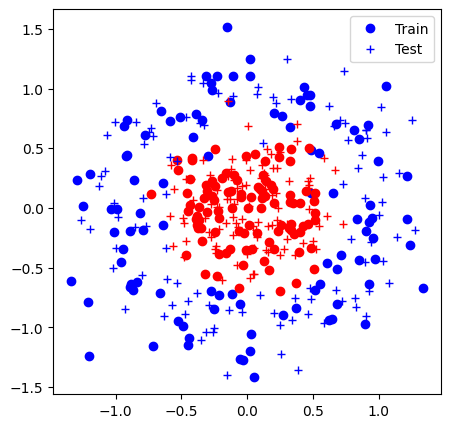

nx 2
nh 10
ny 2
{'Wh': tensor([[-0.0369, -0.3222],
        [ 0.2135,  0.3184],
        [ 0.2718,  0.2481],
        [-0.1692, -0.0662],
        [ 0.1345, -0.0724],
        [ 0.0521, -0.1431],
        [-0.2252,  0.2022],
        [-0.0177, -0.1694],
        [-0.0281, -0.4054],
        [-0.0799, -0.0647]]), 'Wy': tensor([[ 1.9721e-02,  6.0649e-02],
        [-4.7975e-01, -2.6687e-01],
        [ 1.5843e-01, -2.7801e-01],
        [ 6.5281e-02, -5.7081e-01],
        [ 2.2910e-01, -3.2855e-01],
        [ 1.9639e-01, -3.2289e-02],
        [ 9.4592e-02, -6.9910e-01],
        [-6.2097e-01, -2.2233e-05],
        [-5.5528e-01,  5.1196e-01],
        [ 3.0952e-01,  7.2955e-02]]), 'bh': tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]), 'by': tensor([[0.],
        [0.]])}
X shape in main torch.Size([10, 2])
Y shape in main torch.Size([10, 2])
Wy shape torch.Size([10, 2])
Wh shape torch.Size([10, 2])
by shape torc

RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

In [220]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

print("nx", nx)
print("nh", nh)
print("ny", ny)

params = init_params(nx, nh, ny)
print (params)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd

        # Batch forward pass
        print("X shape in main", X.shape)
        print("Y shape in main", Y.shape)
        Yhat, outputs = forward(params, X)

        # computing the loss on the batch
        L, acc = loss_accuracy(Yhat, Y)

        # batch backward pass
        grads = backward(params, outputs, Y)

        # gradient descent
        params = sgd(params, grads, eta)


    ####################
    ##      END        #
    ####################

    #computing and showing the loss and the accuracy on train and test
    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    #showing the decision boundary with plot_data_with_grid
    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 2 : Simplification of the backward pass with `torch.autograd`



In [ ]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by
    # activaye autograd on the network weights

    params["Wh"] = None
    params["Wy"] = None
    params["bh"] = None
    params["by"] = None

    ####################
    ##      END        #
    ####################
    return params

The function `forward` remains unchanged from previous part.

The function `backward` is no longer used because of "autograd".

In [ ]:
def sgd(params, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    params["Wh"] = None
    params["Wy"] = None
    params["bh"] = None
    params["by"] = None

    ####################
    ##      END        #
    ####################
    return params

## Global learning procedure with autograd

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, sgd
        # and the backward function with autograd

    ####################
    ##      END        #
    ####################


    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [ ]:
def init_model(nx, nh, ny):

    #####################
    ## Your code here  ##
    #####################

    model = None
    loss = None

    ####################
    ##      END        #
    ####################

    return model, loss

In [ ]:
def loss_accuracy(loss, Yhat, Y):

    #####################
    ## Your code here  ##
    #####################
    # call the loss function

    L = 0
    acc = 0

    ####################
    ##      END        #
    ####################

    return L, acc

In [ ]:
def sgd(model, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators


    ####################
    ##      END        #
    ####################
    return model

## Global learning procedure with autograd and `torch.nn`

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss = init_model(nx, nh, ny)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd

    ####################
    ##      END        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 4 : Simplification of the SGD with `torch.optim`

In [ ]:
def init_model(nx, nh, ny, eta):

    #####################
    ## Your code here  ##
    #####################

    model = None
    loss = None
    optim = None

    ####################
    ##      END        #
    ####################

    return model, loss, optim

The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after.

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

In [ ]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[],[], [], []]

# epoch
for iteration in range(150):

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j+1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an optimization step

    ####################
    ##      FIN        #
    ####################


    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = 'Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})'.format(iteration, acctrain, Ltrain, acctest, Ltest)
    print(title)
    data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()

# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

In [ ]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas :
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()

def plot_svm_predictions(data, predictions):
      plt.figure(2)
      plt.clf()
      plt.imshow(np.reshape(predictions, (40,40)))
      plt.plot(data._Xtrain[data._Ytrain[:,0] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,0] == 1,1]*10+20, 'bo', label="Train")
      plt.plot(data._Xtrain[data._Ytrain[:,1] == 1,0]*10+20, data._Xtrain[data._Ytrain[:,1] == 1,1]*10+20, 'ro')
      plt.plot(data._Xtest[data._Ytest[:,0] == 1,0]*10+20, data._Xtest[data._Ytest[:,0] == 1,1]*10+20, 'b+', label="Test")
      plt.plot(data._Xtest[data._Ytest[:,1] == 1,0]*10+20, data._Xtest[data._Ytest[:,1] == 1,1]*10+20, 'r+')
      plt.xlim(0,39)
      plt.ylim(0,39)
      plt.clim(0.3,0.7)
      plt.draw()
      plt.pause(1e-3)

In [ ]:
import sklearn.svm

############################
### Your code here   #######
### Train the SVM    #######
## See https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

svm = None

###########################

In [ ]:
## Print results

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)